# Large scale distribution of mutational signatures in Fig 4A

In [1]:
import json

from intervaltree import IntervalTree
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import rcParams
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

In [3]:
sigs_color = {
'SBS1': '#1e79baff',
 'SBS17b': '#ff8921ff'
}

In [4]:
data_dir = './data'

In [5]:
def color_palette(minima, maxima, step): 
    """Function to create a custom color palette"""
    
    tree_colors_fraction = IntervalTree()
    cutoffs = list(np.arange(minima, maxima, step))
    palette = sns.color_palette('viridis', len(cutoffs)).as_hex()
    legend_elements_color = []
    msize = 8
    for c_minus_1, c in enumerate(cutoffs[1:]): 
        start = cutoffs[c_minus_1]
        end = c
        color = palette[c_minus_1]
        tree_colors_fraction.addi(start, end, color)
        legend_elements_color.append(Line2D([0], [0], marker='s', color='w', label=f'({start}, {end})', markerfacecolor=color, markersize=msize))
    legend_elements_color = legend_elements_color[::-1]
    legend_elements_color.append(Line2D([0], [0], marker='s', color='w', label='', markerfacecolor='w', markersize=msize))
    
    return tree_colors_fraction, legend_elements_color

### Load data

- 1 Mpb mappable genomic bins.
- SBS1 and SBS17b COADREAD mutation counts across mappable megabases, obtained from observed data in the cancer type.
- Signal of large scale covariates (chromatin accessibility, replication timing and gene expression) across mappable megabases.

#### Megabases

In [6]:
# Load 1 Mbp bins across autosomes
bins_f = f'{data_dir}/hg38_1000kb_bin.nodrivers.filtered.all_positions.autosomes.bed.gz'
bins_autosom_df = pd.read_csv(bins_f, sep='\t', header=0)
bins_autosom_df.head()

,CHR,START,END,BINID
0,chr1,4000000,5000000,chr1:4000000-5000000
1,chr1,5000000,6000000,chr1:5000000-6000000
2,chr1,8000000,9000000,chr1:8000000-9000000
3,chr1,9000000,10000000,chr1:9000000-10000000
4,chr1,14000000,15000000,chr1:14000000-15000000


In [7]:
# Subset bins in chromosome 1
chromosome = 'chr1'
missing_data = ['chr1:205000000-206000000']    # bins that have a missing covariate annotated are discarded
bins_chr = bins_autosom_df.loc[(bins_autosom_df['CHR'] == chromosome) & (~bins_autosom_df['BINID'].isin(missing_data))].copy()
bins_chr.sort_values(by='START', ascending=True, inplace=True)
bins_chr.head()

,CHR,START,END,BINID
0,chr1,4000000,5000000,chr1:4000000-5000000
1,chr1,5000000,6000000,chr1:5000000-6000000
2,chr1,8000000,9000000,chr1:8000000-9000000
3,chr1,9000000,10000000,chr1:9000000-10000000
4,chr1,14000000,15000000,chr1:14000000-15000000


In [8]:
len(bins_chr)

180

In [9]:
chr_bins = bins_chr['BINID'].tolist()

#### Hotspots

In [10]:
hotspots_d = dict()
for ctype, signature in [('COADREAD', 'SBS1'), ('COADREAD', 'SBS17b')]: 
    hotspots_f = f'{data_dir}/{ctype}.1000kb.hotspots_per_bin.json'
    with open(hotspots_f, 'r') as fd: 
        h_per_bin = json.load(fd)

    hotspots = []
    for binid in chr_bins: 
        binid_data = h_per_bin.get(binid)
        if binid_data:
            hotspots += [binid_data.get(signature, 0)]
    total_hotspots = sum(hotspots)
    y1 = []
    for i, binid in enumerate(chr_bins): 
        binid_data = h_per_bin.get(binid)
        if binid_data:
            y1 += [100*binid_data.get(signature, 0)/total_hotspots]
        else: 
            y1 += [0]
    hotspots_d[signature] = y1

#### Mutations

In [11]:
mutations_d = dict()
for ctype, signature in [('COADREAD', 'SBS1'), ('COADREAD', 'SBS17b')]: 
    muts_f = f'{data_dir}/{ctype}.1000kb.nodrivers.total_maxprob.mutations_per_bin.json'
    with open(muts_f, 'r') as fd: 
        m_per_bin = json.load(fd)

    m = []
    for binid in chr_bins: 
        binid_data = m_per_bin.get(binid)
        if binid_data:
            m += [binid_data.get(signature, 0)]
    total_m = sum(m)

    y2 = []
    for i, binid in enumerate(chr_bins): 
        binid_data = m_per_bin.get(binid)
        if binid_data:
            y2 += [100*binid_data.get(signature, 0)/total_m]
        else: 
            y2 += [0]
    mutations_d[signature] = y2

#### Chromatin accessibility

In [12]:
for ctype in ['COADREAD']: 
    f = f'{data_dir}/{ctype}_hg38_1000kb_bin.DNase.filtered.bed.gz'
    df = pd.read_csv(f, sep='\t', header=0)
    df = df.loc[df['CHR'] == chromosome]
    data_d = dict(list(zip(df['ID'], df['MEAN_SIGNAL'])))
    
    dnase = []
    for binid in chr_bins: 
        dnase += [data_d.get(binid, 0.0)]
        if data_d.get(binid, 0.0) == 0.0: 
            print(binid)

#### Replication

In [13]:
f = f'{data_dir}/SOLID_hg38_1000kb_bin.RepliSeq.filtered.bed.gz'
df = pd.read_csv(f, sep='\t', header=0)
df = df.loc[df['CHR'] == chromosome]
data_d = dict(list(zip(df['ID'], df['MEAN_SIGNAL'])))

repli = []
for binid in chr_bins: 
    repli += [data_d.get(binid, 0.0)]
    if data_d.get(binid, 0.0) == 0.0: 
        print(binid)

#### Gene expression

In [14]:
for ctype in ['COADREAD']: 
    f = f'{data_dir}/{ctype}_hg38_1000kb_bin.rna.filtered.bed.gz'
    df = pd.read_csv(f, sep='\t', header=0)
    df = df.loc[df['CHR'] == chromosome]
    data_d = dict(list(zip(df['ID'], df['MEAN_SIGNAL'])))
    
    rna = []
    for binid in chr_bins: 
        rna += [data_d.get(binid, 0.0)]
        if data_d.get(binid, 0.0) == 0.0: 
            print(binid)

## Panel 4A

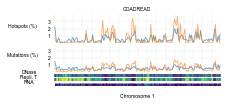

In [17]:
########## Plot params

plt.rc('axes', edgecolor='grey')

fig, ax = plt.subplots(
    5, 
    sharex='col', 
    figsize=(2.9, 1.25), 
     gridspec_kw={'height_ratios': [0.75, 0.75, 0.1, 0.1, 0.1]}
) 
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.05, 
                    hspace=0.05)

x = list(range(len(chr_bins)))

## SUBPLOT 0 
axis_key = 0
for signature, y in hotspots_d.items(): 
    ax[axis_key].plot(x, y, color=sigs_color[signature], lw=0.75, linestyle='-', alpha=0.75)
yticks = [1, 2, 3]
ax[axis_key].set_yticks(yticks)
ax[axis_key].set_yticklabels(yticks)
ax[axis_key].set_ylim(ymin=-0.05, ymax=4)

## SUBPLOT 1 
axis_key = 1
for signature, y in mutations_d.items(): 
    ax[axis_key].plot(x, y, color=sigs_color[signature], lw=0.75, linestyle='-', alpha=0.75)
yticks = [1, 2, 3]
ax[axis_key].set_yticks(yticks)
ax[axis_key].set_yticklabels(yticks)
ax[axis_key].set_ylim(ymin=-0.05, ymax=4)
    
## SUBPLOT 2 
axis_key = 2  
colors = []
tree_colors_fraction, legend = color_palette(min(dnase), max(dnase)+0.1, 0.1)
for binid in dnase: 
    for i in tree_colors_fraction[binid]: 
        colors += [i.data]
ax[axis_key].scatter(x, [1]*len(x), c=colors, marker='|', s=10)
ax[axis_key].set_yticks([])

## SUBPLOT 3 
axis_key = 3
colors = []
tree_colors_fraction, legend = color_palette(min(repli), max(repli)+0.5, 0.5)

for binid in repli: 
    for i in tree_colors_fraction[binid]: 
        colors += [i.data]
ax[axis_key].scatter(x, [1]*len(x), c=colors,  marker='|', s=10)
ax[axis_key].set_yticks([])

## SUBPLOT 4 
axis_key = 4
colors = []
tree_colors_fraction, legend = color_palette(min(rna), max(rna)+0.1, 0.1)
for binid in rna: 
    for i in tree_colors_fraction[binid]: 
        colors += [i.data]
ax[axis_key].scatter(x, [1]*len(x), c=colors,  marker='|', s=10, alpha=1, lw=1)
ax[axis_key].set_yticks([])

########### X axis
ax[axis_key].set_xlabel('Chromosome 1', fontsize=5)
ax[axis_key].set_xticks(np.arange(0, 181, 10))
ax[axis_key].set_xticklabels([])

########## Y axis
ylabels_dict = {
    0: 'Hotspots (%)', 
    1: 'Mutations (%)',
    2: 'DNase',
    3: 'Repli. T',
    4: 'RNA'
}

for key, value in ylabels_dict.items(): 
    ax[key].set_axisbelow(True)
    ax[key].set_ylabel(value, fontsize=5, rotation=0, labelpad=25)
    ax[key].grid(color='lightgrey', linestyle='--', linewidth=0.25)
    for tick in ax[key].yaxis.get_major_ticks():
        tick.label.set_fontsize(5) 
    for tick in ax[key].xaxis.get_major_ticks():
            tick.label.set_fontsize(5) 
            
    for location in ['top', 'bottom', 'left', 'right']:
        ax[key].spines[location].set_linewidth(0.4)
        
    ax[key].tick_params(axis = "x", which = "both", bottom=False)
    ax[key].tick_params(axis = "y", which = "both", left=False)
    
    ax[key].tick_params(axis='both', which='major', pad=0)
    ax[key].spines['right'].set_visible(False)
    ax[key].spines['left'].set_visible(False)
    ax[key].spines['top'].set_visible(False)
    ax[key].spines['bottom'].set_visible(False)
    
plt.tick_params(axis = "x", which = "both", bottom=False)
plt.tick_params(axis = "y", which = "both", left=False)
plt.xlim([-1, 180])
plt.title('COADREAD', fontsize=5, y=18)
    
for extension in ['png']: 
    output = f'./fig_4A.{extension}'
    plt.savefig(output, bbox_inches='tight', dpi=350)

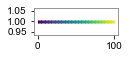

In [18]:
fig = plt.figure(figsize=(1.5, .5))
ax = plt.subplot2grid((1, 1), (0, 0))
    
tree_colors_fraction, legend = color_palette(0, 100+0.1, 0.1)
colors = [list(tree_colors_fraction[a])[0][-1] for a in range(0, 100)]
ax.scatter(list(range(0, 100)), [1]*100, c=colors,  marker='|', s=10, alpha=1, lw=1)

for extension in ['png']: 
    output = f'./fig_4A_figurelegend.{extension}'
    plt.savefig(output, bbox_inches='tight', dpi=350)